In [1]:
import lightgbm as lgb  
import pandas as pd  
import numpy as np  
import xgboost as xgb
from sklearn.metrics import roc_auc_score  
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from collections import Counter
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV  # Perforing grid search
from sklearn.metrics import classification_report
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

preprocessing

In [2]:
df= pd.read_csv('./hackathon_datasets/train/ClaimInfo_Training.csv') 

def apply_datetime(x: pd.Series):
    return pd.to_datetime(x,format='%Y-%m-%d %H:%M:%S')
datetime_cols=['report_date','accident_date','policy_effective_date','original_policy_effective_date','policy_expiry_date','birth_date']
for i in datetime_cols:
    df[i]=apply_datetime(df[i])

df['birth_date']=df['birth_date'].apply(lambda x:x.year-2000)
df['time_f1']=(df['accident_date']-df['report_date']).apply(lambda x:x.days)
df['time_f2']=(df['policy_effective_date']-df['report_date']).apply(lambda x:x.days)
df['time_f3']=(df['original_policy_effective_date']-df['policy_effective_date']).apply(lambda x:x.days)
df['time_f4']=(df['policy_expiry_date']-df['policy_effective_date']).apply(lambda x:x.days)-365
df=df.drop(['report_date','accident_date','policy_effective_date','original_policy_effective_date','policy_expiry_date'],axis=1)


缺失值处理----待完成  
生成新特征&去除原有特征

In [3]:
#数空值 改为0
zero_cols=['history_claimed_amount','history_paid_amount',
           'history_inpatient_days','history_max_inpatient_days','history_inpatient_bill_amount','history_inpatient_paid_amount',
           'history_disease_inpatient_days','history_disease_max_inpatient_days','history_disease_inpatient_bill_amount','history_disease_inpatient_paid_amount',
           'history_outpatient_bill_amount','history_outpatient_paid_amount',
           'history_disease_outpatient_bill_amount','history_disease_outpatient_paid_amount',
           'last_year_inpatient_days','last_year_max_inpatient_days','last_year_inpatient_bill_amount','last_year_inpatient_paid_amount',
          'last_year_disease_inpatient_days','last_year_disease_max_inpatient_days','last_year_disease_inpatient_bill_amount','last_year_disease_inpatient_paid_amount',
          'last_year_outpatient_bill_amount','last_year_outpatient_paid_amount',
          'last_year_disease_outpatient_bill_amount','last_year_disease_outpatient_paid_amount']

#序列号空值 改为-1
minus_one_cols=['history_inpatient_number','history_disease_inpatient_number','history_outpatient_number','history_disease_outpatient_number',
                   'last_year_inpatient_number','last_year_disease_inpatient_number','last_year_outpatient_number','last_year_disease_outpatient_number']

def handle_missing(df):
    unk_cols=['report_source','accident_type','product_name','partner_name','relation_to_holder']
    for i in unk_cols:
        df[i]=df[i].fillna('UNK')
        
    #fill social_security_flag to N if NA, known as not have ssn
    df['social_security_flag'] = df['social_security_flag'].fillna('N')
    
    for i in zero_cols:
        df[i]=df[i].fillna(0)
        
    for i in minus_one_cols:
        df[i]=df[i].fillna(-1)
    #考虑将来把minus_one_cols他们独热编码 
    return df

#改成比例，注意除0
def add_ratio(df):
    df2=pd.DataFrame()
    df2['ratio_f1']=df['history_paid_amount']/(df['history_claimed_amount']+0.00001)
    df2['ratio_f2']=df['history_max_inpatient_days']/(df['history_inpatient_days']+0.00001)
    df2['ratio_f3']=df['history_inpatient_paid_amount']/(df['history_inpatient_bill_amount']+0.00001)
    df2['ratio_f4']=df['history_disease_max_inpatient_days']/(df['history_disease_inpatient_days']+0.00001)
    df2['ratio_f5']=df['history_disease_inpatient_paid_amount']/(df['history_disease_inpatient_bill_amount']+0.00001)
    df2['ratio_f6']=df['history_outpatient_paid_amount']/(df['history_outpatient_bill_amount']+0.00001)
    df2['ratio_f7']=df['history_disease_outpatient_paid_amount']/(df['history_disease_outpatient_bill_amount']+0.00001)
    df2['ratio_f8']=df['last_year_max_inpatient_days']/(df['last_year_inpatient_days']+0.00001)
    df2['ratio_f9']=df['last_year_inpatient_paid_amount']/(df['last_year_inpatient_bill_amount']+0.00001)
    df2['ratio_f10']=df['last_year_disease_max_inpatient_days']/(df['last_year_disease_inpatient_days']+0.00001)
    df2['ratio_f11']=df['last_year_disease_inpatient_paid_amount']/(df['last_year_disease_inpatient_bill_amount']+0.00001)
    df2['ratio_f12']=df['last_year_outpatient_paid_amount']/(df['last_year_outpatient_bill_amount']+0.00001)
    df2['ratio_f13']=df['last_year_disease_outpatient_paid_amount']/(df['last_year_disease_outpatient_bill_amount']+0.00001)
    return df2

df=handle_missing(df)
df2=add_ratio(df)

step2 在claim_billing_info表中统计每个数字的和、总次数

In [4]:
df_aux= pd.read_csv('./hackathon_datasets/train/ClaimBillingInfo_Training.csv') 
df_aux2= pd.read_csv('./hackathon_datasets/train/DiseaseInfo_Training.csv')
df_aux3= pd.read_csv('./hackathon_datasets/train/MedicineFeeInfo_Training.csv')
df_aux=df_aux.merge(df_aux2).merge(df_aux3)
df_aux=pd.concat([df_aux.groupby(['report_no'])['billing_no'].agg(len),pd.concat([df_aux,pd.get_dummies(df_aux.charge_type),pd.get_dummies(df_aux.billing_type),pd.get_dummies(df_aux['100major_disease_flag'],prefix='major100'),pd.get_dummies(df_aux.chronic_disease_type,prefix='chronic'),pd.get_dummies(df_aux.focus_disease_inpatient_flag,prefix='focus'),pd.get_dummies(df_aux.medicine_fee_category)],axis=1).groupby(['report_no']).agg('sum'),],axis=1)
df=df.merge(df_aux.reset_index(),'outer',on=['report_no']).fillna(0)

还需要做的特征工程：1.把charge_type独热后也sum进来
2.把剩下两张表也加进来

minus_one_cols OneHot化

记得加上 不平衡样本的处理

In [6]:
train_x=df.iloc[:,2:]
train_y=df.iloc[:,1]

train_cols=train_x.columns

'''
#注意 现在用的众数填充，将来会针对填充  ---8.25update 已改
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(train_x)
train_x_imputed=imp.transform(train_x)
train_x=pd.DataFrame(train_x_imputed,columns=train_cols)
'''

#注意  不只是文字 还可能有其他的哑变量--后续提升
one_hot_cols=['report_source','accident_type','relation_to_reporter','product_name','partner_name','relation_to_holder','renewal_flag','social_security_flag','gender']
ohe=OneHotEncoder(handle_unknown='ignore')
ohe=OneHotEncoder(sparse=False,handle_unknown='ignore')
ohe.fit(train_x[one_hot_cols].values)
train_x_ohe=ohe.transform(train_x[one_hot_cols].values)

train_x=pd.concat([train_x.drop(one_hot_cols,axis=1),pd.DataFrame(train_x_ohe)],axis=1).astype(float)


#下面用concat再加上新生成的
X, val_X, y, val_y = train_test_split(  
    pd.concat([train_x,df2],axis=1),  
    train_y,  
    test_size=0.2,  
    random_state=1,  
    stratify=train_y # 这里保证分割后y的比例分布与原数据一致  
)  

X_train = X  
y_train = y  
X_test = val_X  
y_test = val_y  

lgb_train = lgb.Dataset(X_train, y_train)  
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)  

params = {  
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'metric': {'binary_logloss', 'auc'},  #二进制对数损失
    'max_depth': 7,  
    'num_leaves': 100,     
    'min_data_in_leaf': 300,  
    'learning_rate': 0.1,  
    'feature_fraction': 0.6,  
    'bagging_fraction': 0.9,  
    'bagging_freq': 5,  
    'lambda_l1': 1,    
    'lambda_l2': 0.01,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.3, 
    'verbose': 0,  
    'is_unbalance': True  
}  



In [11]:
    '''
    'max_depth': 7,  
    'num_leaves': 80,     
    'min_data_in_leaf': 450,  
    'learning_rate': 0.1,  
    'feature_fraction': 0.8,  
    'bagging_fraction': 0.9,  
    'bagging_freq': 5,  
    'lambda_l1': 1,    
    'lambda_l2': 0.001,  # 越小l2正则程度越高  
    'min_gain_to_split': 0.3,  
    '''

"\n'max_depth': 7,  \n'num_leaves': 80,     \n'min_data_in_leaf': 450,  \n'learning_rate': 0.1,  \n'feature_fraction': 0.8,  \n'bagging_fraction': 0.9,  \n'bagging_freq': 5,  \n'lambda_l1': 1,    \n'lambda_l2': 0.001,  # 越小l2正则程度越高  \n'min_gain_to_split': 0.3,  \n"

In [67]:
gbm = lgb.train(params,  
                lgb_train,  
                num_boost_round=10000,  
                valid_sets=lgb_eval,  
                early_stopping_rounds=500)  


[1]	valid_0's auc: 0.800044	valid_0's binary_logloss: 0.479035
Training until validation scores don't improve for 500 rounds
[2]	valid_0's auc: 0.818509	valid_0's binary_logloss: 0.462797
[3]	valid_0's auc: 0.826971	valid_0's binary_logloss: 0.452815
[4]	valid_0's auc: 0.829169	valid_0's binary_logloss: 0.447376
[5]	valid_0's auc: 0.833897	valid_0's binary_logloss: 0.444219
[6]	valid_0's auc: 0.838281	valid_0's binary_logloss: 0.442147
[7]	valid_0's auc: 0.840397	valid_0's binary_logloss: 0.440864
[8]	valid_0's auc: 0.841001	valid_0's binary_logloss: 0.440739
[9]	valid_0's auc: 0.841432	valid_0's binary_logloss: 0.440652
[10]	valid_0's auc: 0.842536	valid_0's binary_logloss: 0.44236
[11]	valid_0's auc: 0.842841	valid_0's binary_logloss: 0.443377
[12]	valid_0's auc: 0.844134	valid_0's binary_logloss: 0.444256
[13]	valid_0's auc: 0.84547	valid_0's binary_logloss: 0.445161
[14]	valid_0's auc: 0.846871	valid_0's binary_logloss: 0.446469
[15]	valid_0's auc: 0.847841	valid_0's binary_logloss

[132]	valid_0's auc: 0.869053	valid_0's binary_logloss: 0.430675
[133]	valid_0's auc: 0.869082	valid_0's binary_logloss: 0.43051
[134]	valid_0's auc: 0.86913	valid_0's binary_logloss: 0.430366
[135]	valid_0's auc: 0.869197	valid_0's binary_logloss: 0.430077
[136]	valid_0's auc: 0.869267	valid_0's binary_logloss: 0.429839
[137]	valid_0's auc: 0.869301	valid_0's binary_logloss: 0.429721
[138]	valid_0's auc: 0.869489	valid_0's binary_logloss: 0.429435
[139]	valid_0's auc: 0.869616	valid_0's binary_logloss: 0.429043
[140]	valid_0's auc: 0.869646	valid_0's binary_logloss: 0.428878
[141]	valid_0's auc: 0.869667	valid_0's binary_logloss: 0.428719
[142]	valid_0's auc: 0.869711	valid_0's binary_logloss: 0.428617
[143]	valid_0's auc: 0.869791	valid_0's binary_logloss: 0.428363
[144]	valid_0's auc: 0.869905	valid_0's binary_logloss: 0.428213
[145]	valid_0's auc: 0.869938	valid_0's binary_logloss: 0.428141
[146]	valid_0's auc: 0.869889	valid_0's binary_logloss: 0.427919
[147]	valid_0's auc: 0.8698

[269]	valid_0's auc: 0.870757	valid_0's binary_logloss: 0.41599
[270]	valid_0's auc: 0.870764	valid_0's binary_logloss: 0.415883
[271]	valid_0's auc: 0.870805	valid_0's binary_logloss: 0.415794
[272]	valid_0's auc: 0.870786	valid_0's binary_logloss: 0.415779
[273]	valid_0's auc: 0.8708	valid_0's binary_logloss: 0.415785
[274]	valid_0's auc: 0.870833	valid_0's binary_logloss: 0.415582
[275]	valid_0's auc: 0.870838	valid_0's binary_logloss: 0.415553
[276]	valid_0's auc: 0.870808	valid_0's binary_logloss: 0.415353
[277]	valid_0's auc: 0.870824	valid_0's binary_logloss: 0.415105
[278]	valid_0's auc: 0.870911	valid_0's binary_logloss: 0.414844
[279]	valid_0's auc: 0.870862	valid_0's binary_logloss: 0.414704
[280]	valid_0's auc: 0.870835	valid_0's binary_logloss: 0.414514
[281]	valid_0's auc: 0.870889	valid_0's binary_logloss: 0.414571
[282]	valid_0's auc: 0.870926	valid_0's binary_logloss: 0.414594
[283]	valid_0's auc: 0.870968	valid_0's binary_logloss: 0.414593
[284]	valid_0's auc: 0.87092

[415]	valid_0's auc: 0.87141	valid_0's binary_logloss: 0.406573
[416]	valid_0's auc: 0.871376	valid_0's binary_logloss: 0.4065
[417]	valid_0's auc: 0.871417	valid_0's binary_logloss: 0.406392
[418]	valid_0's auc: 0.871453	valid_0's binary_logloss: 0.406329
[419]	valid_0's auc: 0.871454	valid_0's binary_logloss: 0.406231
[420]	valid_0's auc: 0.871411	valid_0's binary_logloss: 0.406197
[421]	valid_0's auc: 0.871417	valid_0's binary_logloss: 0.406058
[422]	valid_0's auc: 0.871452	valid_0's binary_logloss: 0.405952
[423]	valid_0's auc: 0.871457	valid_0's binary_logloss: 0.405854
[424]	valid_0's auc: 0.871502	valid_0's binary_logloss: 0.405758
[425]	valid_0's auc: 0.87152	valid_0's binary_logloss: 0.405607
[426]	valid_0's auc: 0.871448	valid_0's binary_logloss: 0.405804
[427]	valid_0's auc: 0.871445	valid_0's binary_logloss: 0.405895
[428]	valid_0's auc: 0.871448	valid_0's binary_logloss: 0.405884
[429]	valid_0's auc: 0.871413	valid_0's binary_logloss: 0.405948
[430]	valid_0's auc: 0.871404

[558]	valid_0's auc: 0.870559	valid_0's binary_logloss: 0.401147
[559]	valid_0's auc: 0.870554	valid_0's binary_logloss: 0.401078
[560]	valid_0's auc: 0.870556	valid_0's binary_logloss: 0.400997
[561]	valid_0's auc: 0.870548	valid_0's binary_logloss: 0.400997
[562]	valid_0's auc: 0.870615	valid_0's binary_logloss: 0.400904
[563]	valid_0's auc: 0.87062	valid_0's binary_logloss: 0.400927
[564]	valid_0's auc: 0.870621	valid_0's binary_logloss: 0.400889
[565]	valid_0's auc: 0.870706	valid_0's binary_logloss: 0.400747
[566]	valid_0's auc: 0.870698	valid_0's binary_logloss: 0.400688
[567]	valid_0's auc: 0.870763	valid_0's binary_logloss: 0.400609
[568]	valid_0's auc: 0.870713	valid_0's binary_logloss: 0.4006
[569]	valid_0's auc: 0.870715	valid_0's binary_logloss: 0.400578
[570]	valid_0's auc: 0.870736	valid_0's binary_logloss: 0.400578
[571]	valid_0's auc: 0.870756	valid_0's binary_logloss: 0.400456
[572]	valid_0's auc: 0.870687	valid_0's binary_logloss: 0.400401
[573]	valid_0's auc: 0.87068

[702]	valid_0's auc: 0.870447	valid_0's binary_logloss: 0.395452
[703]	valid_0's auc: 0.87048	valid_0's binary_logloss: 0.395404
[704]	valid_0's auc: 0.870526	valid_0's binary_logloss: 0.395325
[705]	valid_0's auc: 0.870524	valid_0's binary_logloss: 0.395343
[706]	valid_0's auc: 0.870531	valid_0's binary_logloss: 0.395329
[707]	valid_0's auc: 0.870509	valid_0's binary_logloss: 0.395332
[708]	valid_0's auc: 0.870529	valid_0's binary_logloss: 0.395322
[709]	valid_0's auc: 0.870529	valid_0's binary_logloss: 0.395297
[710]	valid_0's auc: 0.870471	valid_0's binary_logloss: 0.395312
[711]	valid_0's auc: 0.870489	valid_0's binary_logloss: 0.395183
[712]	valid_0's auc: 0.870461	valid_0's binary_logloss: 0.395115
[713]	valid_0's auc: 0.870483	valid_0's binary_logloss: 0.394968
[714]	valid_0's auc: 0.87049	valid_0's binary_logloss: 0.394905
[715]	valid_0's auc: 0.870476	valid_0's binary_logloss: 0.394869
[716]	valid_0's auc: 0.870473	valid_0's binary_logloss: 0.394766
[717]	valid_0's auc: 0.8704

[846]	valid_0's auc: 0.869493	valid_0's binary_logloss: 0.393363
[847]	valid_0's auc: 0.86947	valid_0's binary_logloss: 0.393381
[848]	valid_0's auc: 0.869482	valid_0's binary_logloss: 0.393415
[849]	valid_0's auc: 0.869467	valid_0's binary_logloss: 0.393325
[850]	valid_0's auc: 0.869446	valid_0's binary_logloss: 0.393358
[851]	valid_0's auc: 0.869418	valid_0's binary_logloss: 0.393331
[852]	valid_0's auc: 0.869388	valid_0's binary_logloss: 0.393333
[853]	valid_0's auc: 0.869399	valid_0's binary_logloss: 0.393298
[854]	valid_0's auc: 0.869297	valid_0's binary_logloss: 0.393371
[855]	valid_0's auc: 0.869312	valid_0's binary_logloss: 0.393337
[856]	valid_0's auc: 0.869322	valid_0's binary_logloss: 0.393264
[857]	valid_0's auc: 0.869318	valid_0's binary_logloss: 0.393262
[858]	valid_0's auc: 0.86934	valid_0's binary_logloss: 0.393206
[859]	valid_0's auc: 0.869316	valid_0's binary_logloss: 0.393197
[860]	valid_0's auc: 0.869332	valid_0's binary_logloss: 0.393139
[861]	valid_0's auc: 0.8693

In [68]:
lgb_train2=lgb.Dataset(pd.concat([train_x,df2],axis=1),train_y)
gbm = lgb.train(params,  
                lgb_train2,  
                num_boost_round=500)  

parameters = {'max_depth': [15, 20, 25, 30, 35],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
              'feature_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 0.95],
              'bagging_freq': [2, 4, 5, 6, 8],
              'lambda_l1': [0, 0.1, 0.4, 0.5, 0.6],
              'lambda_l2': [0, 10, 15, 35, 40],
              'cat_smooth': [1, 10, 15, 20, 35]
}
gbm = lgb.LGBMClassifier(boosting_type='gbdt',
                         objective = 'binary',
                         metric = 'auc',
                         verbose = 0,
                         learning_rate = 0.01,
                         num_leaves = 35,
                         feature_fraction=0.8,
                         bagging_fraction= 0.9,
                         bagging_freq= 8,
                         lambda_l1= 0.6,
                         lambda_l2= 0)
gsearch = GridSearchCV(gbm, param_grid=parameters, scoring='accuracy', cv=5)
gsearch.fit(pd.concat([train_x,df2],axis=1), train_y)

print("Best score: %0.3f" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

xgboost

In [26]:
#xgb_train = xgb.DMatrix(pd.concat([train_x,df2],axis=1), label=train_y)
xgb_train = xgb.DMatrix(X_train, y_train)  
xgb_eval = xgb.DMatrix(X_test, y_test)  
'''
clf = xgb.XGBClassifier(
    missing=9999999999,
    max_depth = 7, min_child_weight = 3,
    gamma=0.8,
    colsample_bytree=0.9,
    n_estimators=400,
    learning_rate=0.01, 
    objective='binary:logistic',
    subsample=1.0,
    scale_pos_weight = 2,
    seed=1301
)


print('Fit on the training data')
clf.fit(X_train, y_train, eval_metric='error')#训练clf
'''




print('Fit on the testing data')
print(classification_report(y_test, clf.predict(X_test)))

Fit on the testing data


NameError: name 'clf' is not defined

In [61]:
params={'booster':'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth':7,
    'lambda':3,
    'subsample':0.75,
    'colsample_bytree':0.75,
    'min_child_weight':1,
    'eta': 0.01,
    'seed':0,
    'nthread':8,
     'silent':1}

In [62]:
watchlist = [(xgb_train,'train'),(xgb_eval,'test')]
bst=xgb.train(params,xgb_train,num_boost_round=1000,early_stopping_rounds=500,evals=watchlist)

[12:01:57] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.82439	test-auc:0.81939
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 500 rounds.
[1]	train-auc:0.82682	test-auc:0.82141
[2]	train-auc:0.83773	test-auc:0.82841
[3]	train-auc:0.83751	test-auc:0.82733
[4]	train-auc:0.84156	test-auc:0.83021
[5]	train-auc:0.84202	test-auc:0.83069
[6]	train-auc:0.84142	test-auc:0.83083
[7]	train-auc:0.84122	test-auc:0.83077
[8]	train-auc:0.84148	test-auc:0.83058
[9]	train-auc:0.84179	test-auc:0.83090
[10]	train-auc:0.84194	test-auc:0.83113
[11]	train-auc:0.84176	test-auc:0.83091
[12]

[190]	train-auc:0.86935	test-auc:0.85100
[191]	train-auc:0.86946	test-auc:0.85109
[192]	train-auc:0.86957	test-auc:0.85115
[193]	train-auc:0.86970	test-auc:0.85120
[194]	train-auc:0.86988	test-auc:0.85128
[195]	train-auc:0.87000	test-auc:0.85135
[196]	train-auc:0.87018	test-auc:0.85145
[197]	train-auc:0.87033	test-auc:0.85152
[198]	train-auc:0.87035	test-auc:0.85154
[199]	train-auc:0.87048	test-auc:0.85165
[200]	train-auc:0.87058	test-auc:0.85175
[201]	train-auc:0.87066	test-auc:0.85179
[202]	train-auc:0.87080	test-auc:0.85194
[203]	train-auc:0.87095	test-auc:0.85202
[204]	train-auc:0.87101	test-auc:0.85204
[205]	train-auc:0.87114	test-auc:0.85217
[206]	train-auc:0.87131	test-auc:0.85223
[207]	train-auc:0.87144	test-auc:0.85235
[208]	train-auc:0.87156	test-auc:0.85244
[209]	train-auc:0.87161	test-auc:0.85246
[210]	train-auc:0.87191	test-auc:0.85270
[211]	train-auc:0.87202	test-auc:0.85279
[212]	train-auc:0.87208	test-auc:0.85280
[213]	train-auc:0.87222	test-auc:0.85288
[214]	train-auc:

[390]	train-auc:0.88861	test-auc:0.86194
[391]	train-auc:0.88869	test-auc:0.86197
[392]	train-auc:0.88874	test-auc:0.86199
[393]	train-auc:0.88878	test-auc:0.86200
[394]	train-auc:0.88886	test-auc:0.86203
[395]	train-auc:0.88894	test-auc:0.86205
[396]	train-auc:0.88905	test-auc:0.86210
[397]	train-auc:0.88911	test-auc:0.86213
[398]	train-auc:0.88918	test-auc:0.86216
[399]	train-auc:0.88926	test-auc:0.86220
[400]	train-auc:0.88936	test-auc:0.86225
[401]	train-auc:0.88950	test-auc:0.86234
[402]	train-auc:0.88955	test-auc:0.86235
[403]	train-auc:0.88960	test-auc:0.86237
[404]	train-auc:0.88968	test-auc:0.86241
[405]	train-auc:0.88974	test-auc:0.86243
[406]	train-auc:0.88980	test-auc:0.86246
[407]	train-auc:0.88986	test-auc:0.86249
[408]	train-auc:0.88991	test-auc:0.86250
[409]	train-auc:0.88995	test-auc:0.86253
[410]	train-auc:0.89002	test-auc:0.86256
[411]	train-auc:0.89013	test-auc:0.86261
[412]	train-auc:0.89019	test-auc:0.86264
[413]	train-auc:0.89025	test-auc:0.86270
[414]	train-auc:

[590]	train-auc:0.90327	test-auc:0.86730
[591]	train-auc:0.90335	test-auc:0.86731
[592]	train-auc:0.90343	test-auc:0.86733
[593]	train-auc:0.90353	test-auc:0.86733
[594]	train-auc:0.90361	test-auc:0.86734
[595]	train-auc:0.90371	test-auc:0.86736
[596]	train-auc:0.90379	test-auc:0.86737
[597]	train-auc:0.90384	test-auc:0.86738
[598]	train-auc:0.90392	test-auc:0.86741
[599]	train-auc:0.90402	test-auc:0.86745
[600]	train-auc:0.90416	test-auc:0.86747
[601]	train-auc:0.90425	test-auc:0.86749
[602]	train-auc:0.90436	test-auc:0.86755
[603]	train-auc:0.90450	test-auc:0.86757
[604]	train-auc:0.90456	test-auc:0.86761
[605]	train-auc:0.90459	test-auc:0.86760
[606]	train-auc:0.90468	test-auc:0.86762
[607]	train-auc:0.90477	test-auc:0.86766
[608]	train-auc:0.90486	test-auc:0.86767
[609]	train-auc:0.90497	test-auc:0.86771
[610]	train-auc:0.90503	test-auc:0.86773
[611]	train-auc:0.90509	test-auc:0.86774
[612]	train-auc:0.90515	test-auc:0.86774
[613]	train-auc:0.90524	test-auc:0.86777
[614]	train-auc:

[790]	train-auc:0.91705	test-auc:0.87016
[791]	train-auc:0.91716	test-auc:0.87020
[792]	train-auc:0.91723	test-auc:0.87021
[793]	train-auc:0.91726	test-auc:0.87022
[794]	train-auc:0.91731	test-auc:0.87025
[795]	train-auc:0.91735	test-auc:0.87025
[796]	train-auc:0.91743	test-auc:0.87027
[797]	train-auc:0.91747	test-auc:0.87028
[798]	train-auc:0.91751	test-auc:0.87029
[799]	train-auc:0.91764	test-auc:0.87032
[800]	train-auc:0.91771	test-auc:0.87033
[801]	train-auc:0.91777	test-auc:0.87034
[802]	train-auc:0.91781	test-auc:0.87033
[803]	train-auc:0.91786	test-auc:0.87035
[804]	train-auc:0.91796	test-auc:0.87037
[805]	train-auc:0.91802	test-auc:0.87038
[806]	train-auc:0.91805	test-auc:0.87037
[807]	train-auc:0.91810	test-auc:0.87039
[808]	train-auc:0.91820	test-auc:0.87041
[809]	train-auc:0.91825	test-auc:0.87043
[810]	train-auc:0.91835	test-auc:0.87046
[811]	train-auc:0.91837	test-auc:0.87046
[812]	train-auc:0.91849	test-auc:0.87045
[813]	train-auc:0.91854	test-auc:0.87046
[814]	train-auc:

[990]	train-auc:0.92765	test-auc:0.87201
[991]	train-auc:0.92771	test-auc:0.87200
[992]	train-auc:0.92776	test-auc:0.87202
[993]	train-auc:0.92785	test-auc:0.87202
[994]	train-auc:0.92791	test-auc:0.87204
[995]	train-auc:0.92798	test-auc:0.87205
[996]	train-auc:0.92805	test-auc:0.87209
[997]	train-auc:0.92813	test-auc:0.87210
[998]	train-auc:0.92817	test-auc:0.87209
[999]	train-auc:0.92820	test-auc:0.87210


In [63]:
xgb_train2=xgb.DMatrix(pd.concat([train_x,df2],axis=1),train_y)
watchlist = [(xgb_train2,'train')]
xgbst = xgb.train(params,  
                xgb_train2,  
                num_boost_round=1000,
                 evals=watchlist)  

[12:03:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.82185
[1]	train-auc:0.82317
[2]	train-auc:0.82550
[3]	train-auc:0.83488
[4]	train-auc:0.83543
[5]	train-auc:0.83663
[6]	train-auc:0.83663
[7]	train-auc:0.83642
[8]	train-auc:0.83616
[9]	train-auc:0.83674
[10]	train-auc:0.83649
[11]	train-auc:0.83672
[12]	train-auc:0.83708
[13]	train-auc:0.84026
[14]	train-auc:0.84044
[15]	train-auc:0.84034
[16]	train-auc:0.84025
[17]	train-auc:0.84030
[18]	train-auc:0.84143
[19]	train-auc:0.84263
[20]	train-auc:0.84279
[21]	train-auc:0.84353
[22]	train-auc:0.84340
[23]	train-auc:0.84336
[24]	train-auc:0.84347
[25]	train-auc:0.84366
[26]	train-auc:0.84461
[27]	

[330]	train-auc:0.88083
[331]	train-auc:0.88092
[332]	train-auc:0.88101
[333]	train-auc:0.88110
[334]	train-auc:0.88121
[335]	train-auc:0.88128
[336]	train-auc:0.88133
[337]	train-auc:0.88142
[338]	train-auc:0.88146
[339]	train-auc:0.88159
[340]	train-auc:0.88165
[341]	train-auc:0.88176
[342]	train-auc:0.88179
[343]	train-auc:0.88186
[344]	train-auc:0.88193
[345]	train-auc:0.88201
[346]	train-auc:0.88212
[347]	train-auc:0.88219
[348]	train-auc:0.88226
[349]	train-auc:0.88233
[350]	train-auc:0.88245
[351]	train-auc:0.88250
[352]	train-auc:0.88259
[353]	train-auc:0.88272
[354]	train-auc:0.88278
[355]	train-auc:0.88289
[356]	train-auc:0.88301
[357]	train-auc:0.88307
[358]	train-auc:0.88311
[359]	train-auc:0.88316
[360]	train-auc:0.88323
[361]	train-auc:0.88331
[362]	train-auc:0.88337
[363]	train-auc:0.88344
[364]	train-auc:0.88355
[365]	train-auc:0.88364
[366]	train-auc:0.88372
[367]	train-auc:0.88379
[368]	train-auc:0.88387
[369]	train-auc:0.88394
[370]	train-auc:0.88397
[371]	train-auc:

[672]	train-auc:0.90457
[673]	train-auc:0.90465
[674]	train-auc:0.90469
[675]	train-auc:0.90474
[676]	train-auc:0.90485
[677]	train-auc:0.90492
[678]	train-auc:0.90498
[679]	train-auc:0.90503
[680]	train-auc:0.90509
[681]	train-auc:0.90516
[682]	train-auc:0.90520
[683]	train-auc:0.90526
[684]	train-auc:0.90529
[685]	train-auc:0.90536
[686]	train-auc:0.90538
[687]	train-auc:0.90541
[688]	train-auc:0.90548
[689]	train-auc:0.90553
[690]	train-auc:0.90564
[691]	train-auc:0.90571
[692]	train-auc:0.90578
[693]	train-auc:0.90581
[694]	train-auc:0.90586
[695]	train-auc:0.90590
[696]	train-auc:0.90593
[697]	train-auc:0.90601
[698]	train-auc:0.90612
[699]	train-auc:0.90619
[700]	train-auc:0.90624
[701]	train-auc:0.90632
[702]	train-auc:0.90637
[703]	train-auc:0.90642
[704]	train-auc:0.90647
[705]	train-auc:0.90651
[706]	train-auc:0.90660
[707]	train-auc:0.90666
[708]	train-auc:0.90673
[709]	train-auc:0.90677
[710]	train-auc:0.90682
[711]	train-auc:0.90691
[712]	train-auc:0.90700
[713]	train-auc:

xgb predict

In [64]:
xgb_results = xgbst.predict(xgb.DMatrix(pd.concat([test_x,df_p2],axis=1)))

keras

In [12]:
scaler = StandardScaler()
scaler.fit(pd.concat([train_x,test_x],axis=0))
train_x_neu = scaler.transform(train_x)

X, val_X, y, val_y = train_test_split(  
    np.hstack((train_x_neu,df2)),  
    train_y,  
    test_size=0.2,  
    random_state=1,  
    stratify=train_y # 这里保证分割后y的比例分布与原数据一致  
)  

X_train = X  
y_train = y  
X_test = val_X  
y_test = val_y  

In [20]:
import tensorflow as tf
import keras
from keras import models,layers,losses,metrics,optimizers
from keras import backend as K
from sklearn.metrics import f1_score

model = models.Sequential()
model.add(layers.Dense(150, activation='relu', input_shape=(131,)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
 
    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*precision*recall/(precision+recall+K.epsilon())


model.compile(optimizer=optimizers.Adam(lr=0.0001),#optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])


history = model.fit(X_train,
                    y_train,
                    epochs=800,
                    batch_size=10240,
                    validation_data=(X_test, y_test))



Train on 48000 samples, validate on 12000 samples
Epoch 1/800
48000/48000 [==============================] - 1s 15us/step - loss: 0.9363 - binary_accuracy: 0.3769 - val_loss: 0.7712 - val_binary_accuracy: 0.3706
Epoch 2/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.8534 - binary_accuracy: 0.4312 - val_loss: 0.7040 - val_binary_accuracy: 0.4771
Epoch 3/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.7804 - binary_accuracy: 0.4834 - val_loss: 0.6491 - val_binary_accuracy: 0.5927
Epoch 4/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.7205 - binary_accuracy: 0.5410 - val_loss: 0.6053 - val_binary_accuracy: 0.6847
Epoch 5/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.6738 - binary_accuracy: 0.5946 - val_loss: 0.5712 - val_binary_accuracy: 0.7455
Epoch 6/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.6372 - binary_accuracy: 0.6335 - val_loss: 0.5449 - val_binary_

48000/48000 [==============================] - 0s 2us/step - loss: 0.4631 - binary_accuracy: 0.7909 - val_loss: 0.4308 - val_binary_accuracy: 0.7961
Epoch 52/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4605 - binary_accuracy: 0.7919 - val_loss: 0.4302 - val_binary_accuracy: 0.7961
Epoch 53/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4611 - binary_accuracy: 0.7920 - val_loss: 0.4296 - val_binary_accuracy: 0.7962
Epoch 54/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4588 - binary_accuracy: 0.7935 - val_loss: 0.4290 - val_binary_accuracy: 0.7965
Epoch 55/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4588 - binary_accuracy: 0.7929 - val_loss: 0.4284 - val_binary_accuracy: 0.7965
Epoch 56/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4579 - binary_accuracy: 0.7917 - val_loss: 0.4278 - val_binary_accuracy: 0.7966
Epoch 57/800
48000/48000 [===============

48000/48000 [==============================] - 0s 2us/step - loss: 0.4333 - binary_accuracy: 0.7979 - val_loss: 0.4110 - val_binary_accuracy: 0.8067
Epoch 102/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4314 - binary_accuracy: 0.7989 - val_loss: 0.4107 - val_binary_accuracy: 0.8071
Epoch 103/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4320 - binary_accuracy: 0.7987 - val_loss: 0.4104 - val_binary_accuracy: 0.8072
Epoch 104/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4323 - binary_accuracy: 0.7981 - val_loss: 0.4102 - val_binary_accuracy: 0.8075
Epoch 105/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4328 - binary_accuracy: 0.7985 - val_loss: 0.4100 - val_binary_accuracy: 0.8077
Epoch 106/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4315 - binary_accuracy: 0.7993 - val_loss: 0.4099 - val_binary_accuracy: 0.8082
Epoch 107/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.4201 - binary_accuracy: 0.8052 - val_loss: 0.4025 - val_binary_accuracy: 0.8159
Epoch 152/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4174 - binary_accuracy: 0.8068 - val_loss: 0.4024 - val_binary_accuracy: 0.8159
Epoch 153/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4182 - binary_accuracy: 0.8047 - val_loss: 0.4023 - val_binary_accuracy: 0.8159
Epoch 154/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4180 - binary_accuracy: 0.8062 - val_loss: 0.4022 - val_binary_accuracy: 0.8162
Epoch 155/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4184 - binary_accuracy: 0.8057 - val_loss: 0.4021 - val_binary_accuracy: 0.8162
Epoch 156/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4172 - binary_accuracy: 0.8057 - val_loss: 0.4020 - val_binary_accuracy: 0.8165
Epoch 157/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.4090 - binary_accuracy: 0.8099 - val_loss: 0.3968 - val_binary_accuracy: 0.8203
Epoch 202/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4094 - binary_accuracy: 0.8095 - val_loss: 0.3967 - val_binary_accuracy: 0.8203
Epoch 203/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4093 - binary_accuracy: 0.8095 - val_loss: 0.3966 - val_binary_accuracy: 0.8204
Epoch 204/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4094 - binary_accuracy: 0.8092 - val_loss: 0.3965 - val_binary_accuracy: 0.8208
Epoch 205/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4086 - binary_accuracy: 0.8100 - val_loss: 0.3964 - val_binary_accuracy: 0.8207
Epoch 206/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4101 - binary_accuracy: 0.8098 - val_loss: 0.3963 - val_binary_accuracy: 0.8209
Epoch 207/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.4031 - binary_accuracy: 0.8139 - val_loss: 0.3919 - val_binary_accuracy: 0.8227
Epoch 252/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4041 - binary_accuracy: 0.8134 - val_loss: 0.3918 - val_binary_accuracy: 0.8228
Epoch 253/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4004 - binary_accuracy: 0.8150 - val_loss: 0.3918 - val_binary_accuracy: 0.8229
Epoch 254/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4018 - binary_accuracy: 0.8146 - val_loss: 0.3916 - val_binary_accuracy: 0.8230
Epoch 255/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.4010 - binary_accuracy: 0.8143 - val_loss: 0.3915 - val_binary_accuracy: 0.8230
Epoch 256/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3990 - binary_accuracy: 0.8142 - val_loss: 0.3914 - val_binary_accuracy: 0.8233
Epoch 257/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3955 - binary_accuracy: 0.8160 - val_loss: 0.3874 - val_binary_accuracy: 0.8265
Epoch 302/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3947 - binary_accuracy: 0.8190 - val_loss: 0.3873 - val_binary_accuracy: 0.8269
Epoch 303/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3962 - binary_accuracy: 0.8183 - val_loss: 0.3871 - val_binary_accuracy: 0.8266
Epoch 304/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3947 - binary_accuracy: 0.8170 - val_loss: 0.3870 - val_binary_accuracy: 0.8266
Epoch 305/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3951 - binary_accuracy: 0.8189 - val_loss: 0.3869 - val_binary_accuracy: 0.8268
Epoch 306/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3940 - binary_accuracy: 0.8190 - val_loss: 0.3868 - val_binary_accuracy: 0.8269
Epoch 307/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3886 - binary_accuracy: 0.8215 - val_loss: 0.3829 - val_binary_accuracy: 0.8287
Epoch 352/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3880 - binary_accuracy: 0.8212 - val_loss: 0.3828 - val_binary_accuracy: 0.8286
Epoch 353/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3881 - binary_accuracy: 0.8225 - val_loss: 0.3827 - val_binary_accuracy: 0.8287
Epoch 354/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3893 - binary_accuracy: 0.8215 - val_loss: 0.3827 - val_binary_accuracy: 0.8288
Epoch 355/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3879 - binary_accuracy: 0.8225 - val_loss: 0.3826 - val_binary_accuracy: 0.8289
Epoch 356/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3871 - binary_accuracy: 0.8226 - val_loss: 0.3824 - val_binary_accuracy: 0.8288
Epoch 357/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3825 - binary_accuracy: 0.8243 - val_loss: 0.3785 - val_binary_accuracy: 0.8318
Epoch 402/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3840 - binary_accuracy: 0.8249 - val_loss: 0.3783 - val_binary_accuracy: 0.8317
Epoch 403/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3822 - binary_accuracy: 0.8254 - val_loss: 0.3783 - val_binary_accuracy: 0.8317
Epoch 404/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3820 - binary_accuracy: 0.8246 - val_loss: 0.3783 - val_binary_accuracy: 0.8316
Epoch 405/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3833 - binary_accuracy: 0.8259 - val_loss: 0.3782 - val_binary_accuracy: 0.8316
Epoch 406/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3828 - binary_accuracy: 0.8240 - val_loss: 0.3782 - val_binary_accuracy: 0.8315
Epoch 407/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3774 - binary_accuracy: 0.8269 - val_loss: 0.3743 - val_binary_accuracy: 0.8341
Epoch 452/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3785 - binary_accuracy: 0.8281 - val_loss: 0.3742 - val_binary_accuracy: 0.8346
Epoch 453/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3795 - binary_accuracy: 0.8283 - val_loss: 0.3741 - val_binary_accuracy: 0.8344
Epoch 454/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3775 - binary_accuracy: 0.8282 - val_loss: 0.3740 - val_binary_accuracy: 0.8340
Epoch 455/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3776 - binary_accuracy: 0.8290 - val_loss: 0.3740 - val_binary_accuracy: 0.8340
Epoch 456/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3783 - binary_accuracy: 0.8291 - val_loss: 0.3739 - val_binary_accuracy: 0.8341
Epoch 457/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3717 - binary_accuracy: 0.8308 - val_loss: 0.3701 - val_binary_accuracy: 0.8363
Epoch 502/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3724 - binary_accuracy: 0.8321 - val_loss: 0.3701 - val_binary_accuracy: 0.8361
Epoch 503/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3722 - binary_accuracy: 0.8311 - val_loss: 0.3700 - val_binary_accuracy: 0.8366
Epoch 504/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3719 - binary_accuracy: 0.8318 - val_loss: 0.3699 - val_binary_accuracy: 0.8363
Epoch 505/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3728 - binary_accuracy: 0.8310 - val_loss: 0.3700 - val_binary_accuracy: 0.8358
Epoch 506/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3728 - binary_accuracy: 0.8313 - val_loss: 0.3700 - val_binary_accuracy: 0.8358
Epoch 507/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3674 - binary_accuracy: 0.8346 - val_loss: 0.3658 - val_binary_accuracy: 0.8387
Epoch 552/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3658 - binary_accuracy: 0.8357 - val_loss: 0.3657 - val_binary_accuracy: 0.8384
Epoch 553/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3675 - binary_accuracy: 0.8350 - val_loss: 0.3656 - val_binary_accuracy: 0.8392
Epoch 554/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3666 - binary_accuracy: 0.8345 - val_loss: 0.3656 - val_binary_accuracy: 0.8392
Epoch 555/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3665 - binary_accuracy: 0.8342 - val_loss: 0.3656 - val_binary_accuracy: 0.8389
Epoch 556/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3662 - binary_accuracy: 0.8343 - val_loss: 0.3655 - val_binary_accuracy: 0.8387
Epoch 557/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3627 - binary_accuracy: 0.8374 - val_loss: 0.3617 - val_binary_accuracy: 0.8402
Epoch 602/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3625 - binary_accuracy: 0.8382 - val_loss: 0.3616 - val_binary_accuracy: 0.8405
Epoch 603/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3626 - binary_accuracy: 0.8372 - val_loss: 0.3615 - val_binary_accuracy: 0.8405
Epoch 604/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3621 - binary_accuracy: 0.8375 - val_loss: 0.3614 - val_binary_accuracy: 0.8402
Epoch 605/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3628 - binary_accuracy: 0.8379 - val_loss: 0.3614 - val_binary_accuracy: 0.8404
Epoch 606/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3615 - binary_accuracy: 0.8390 - val_loss: 0.3613 - val_binary_accuracy: 0.8402
Epoch 607/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3595 - binary_accuracy: 0.8403 - val_loss: 0.3582 - val_binary_accuracy: 0.8423
Epoch 652/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3594 - binary_accuracy: 0.8400 - val_loss: 0.3581 - val_binary_accuracy: 0.8423
Epoch 653/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3567 - binary_accuracy: 0.8405 - val_loss: 0.3581 - val_binary_accuracy: 0.8420
Epoch 654/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3570 - binary_accuracy: 0.8403 - val_loss: 0.3580 - val_binary_accuracy: 0.8424
Epoch 655/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3580 - binary_accuracy: 0.8404 - val_loss: 0.3580 - val_binary_accuracy: 0.8425
Epoch 656/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3594 - binary_accuracy: 0.8391 - val_loss: 0.3579 - val_binary_accuracy: 0.8423
Epoch 657/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3544 - binary_accuracy: 0.8417 - val_loss: 0.3557 - val_binary_accuracy: 0.8427
Epoch 702/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3536 - binary_accuracy: 0.8426 - val_loss: 0.3556 - val_binary_accuracy: 0.8427
Epoch 703/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3536 - binary_accuracy: 0.8427 - val_loss: 0.3556 - val_binary_accuracy: 0.8429
Epoch 704/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3533 - binary_accuracy: 0.8424 - val_loss: 0.3556 - val_binary_accuracy: 0.8432
Epoch 705/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3535 - binary_accuracy: 0.8420 - val_loss: 0.3555 - val_binary_accuracy: 0.8432
Epoch 706/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3543 - binary_accuracy: 0.8426 - val_loss: 0.3555 - val_binary_accuracy: 0.8426
Epoch 707/800
48000/48000 [=========

48000/48000 [==============================] - 0s 2us/step - loss: 0.3502 - binary_accuracy: 0.8433 - val_loss: 0.3538 - val_binary_accuracy: 0.8444
Epoch 752/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3475 - binary_accuracy: 0.8450 - val_loss: 0.3537 - val_binary_accuracy: 0.8446
Epoch 753/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3483 - binary_accuracy: 0.8448 - val_loss: 0.3536 - val_binary_accuracy: 0.8444
Epoch 754/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3495 - binary_accuracy: 0.8440 - val_loss: 0.3536 - val_binary_accuracy: 0.8445
Epoch 755/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3490 - binary_accuracy: 0.8450 - val_loss: 0.3537 - val_binary_accuracy: 0.8445
Epoch 756/800
48000/48000 [==============================] - 0s 2us/step - loss: 0.3505 - binary_accuracy: 0.8447 - val_loss: 0.3537 - val_binary_accuracy: 0.8445
Epoch 757/800
48000/48000 [=========

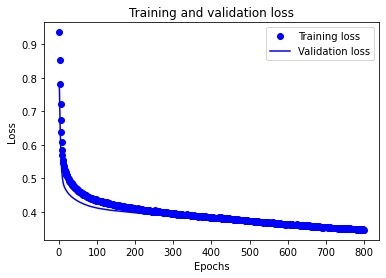

In [21]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

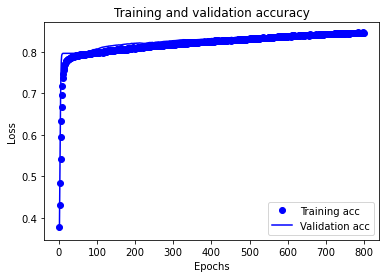

In [22]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [23]:
history = model.fit(np.hstack((train_x_neu,df2)),  
                    train_y, 
                    epochs=800,
                    batch_size=10240)

Epoch 1/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3513 - binary_accuracy: 0.8445
Epoch 2/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3524 - binary_accuracy: 0.8449
Epoch 3/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3507 - binary_accuracy: 0.8437
Epoch 4/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3517 - binary_accuracy: 0.8455
Epoch 5/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3506 - binary_accuracy: 0.8434
Epoch 6/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3506 - binary_accuracy: 0.8447
Epoch 7/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3511 - binary_accuracy: 0.8451
Epoch 8/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3498 - binary_accuracy: 0.8446
Epoch 9/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3500 - binary_accuracy:

60000/60000 [==============================] - 0s 3us/step - loss: 0.3468 - binary_accuracy: 0.8475
Epoch 74/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3456 - binary_accuracy: 0.8465
Epoch 75/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3464 - binary_accuracy: 0.8469
Epoch 76/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3470 - binary_accuracy: 0.8475
Epoch 77/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3450 - binary_accuracy: 0.8469
Epoch 78/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3453 - binary_accuracy: 0.8467
Epoch 79/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3443 - binary_accuracy: 0.8481
Epoch 80/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3456 - binary_accuracy: 0.8469
Epoch 81/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3456 - binary_accuracy: 0.8

60000/60000 [==============================] - 0s 2us/step - loss: 0.3417 - binary_accuracy: 0.8492
Epoch 146/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3412 - binary_accuracy: 0.8493
Epoch 147/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3424 - binary_accuracy: 0.8479
Epoch 148/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3417 - binary_accuracy: 0.8487
Epoch 149/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3432 - binary_accuracy: 0.8487
Epoch 150/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3415 - binary_accuracy: 0.8505
Epoch 151/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3427 - binary_accuracy: 0.8491
Epoch 152/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3417 - binary_accuracy: 0.8496
Epoch 153/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3417 - binary_accur

Epoch 217/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3391 - binary_accuracy: 0.8505
Epoch 218/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3391 - binary_accuracy: 0.8506
Epoch 219/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3389 - binary_accuracy: 0.8496
Epoch 220/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3387 - binary_accuracy: 0.8498
Epoch 221/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3380 - binary_accuracy: 0.8504
Epoch 222/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3386 - binary_accuracy: 0.8497
Epoch 223/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3378 - binary_accuracy: 0.8499
Epoch 224/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3390 - binary_accuracy: 0.8512
Epoch 225/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3385 

60000/60000 [==============================] - 0s 2us/step - loss: 0.3355 - binary_accuracy: 0.8523
Epoch 289/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3351 - binary_accuracy: 0.8517
Epoch 290/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3358 - binary_accuracy: 0.8532
Epoch 291/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3352 - binary_accuracy: 0.8529
Epoch 292/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3368 - binary_accuracy: 0.8518
Epoch 293/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3362 - binary_accuracy: 0.8510
Epoch 294/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3361 - binary_accuracy: 0.8516
Epoch 295/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3351 - binary_accuracy: 0.8514
Epoch 296/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3364 - binary_accur

Epoch 360/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3337 - binary_accuracy: 0.8532
Epoch 361/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3340 - binary_accuracy: 0.8528
Epoch 362/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3322 - binary_accuracy: 0.8534
Epoch 363/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3326 - binary_accuracy: 0.8529
Epoch 364/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3327 - binary_accuracy: 0.8536
Epoch 365/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3337 - binary_accuracy: 0.8528
Epoch 366/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3341 - binary_accuracy: 0.8525
Epoch 367/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3341 - binary_accuracy: 0.8529
Epoch 368/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3332 

60000/60000 [==============================] - 0s 2us/step - loss: 0.3310 - binary_accuracy: 0.8542
Epoch 432/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3304 - binary_accuracy: 0.8539
Epoch 433/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3310 - binary_accuracy: 0.8551
Epoch 434/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3295 - binary_accuracy: 0.8553
Epoch 435/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3305 - binary_accuracy: 0.8548
Epoch 436/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3303 - binary_accuracy: 0.8540
Epoch 437/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3293 - binary_accuracy: 0.8550
Epoch 438/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3304 - binary_accuracy: 0.8544
Epoch 439/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3303 - binary_accur

Epoch 503/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3285 - binary_accuracy: 0.8550
Epoch 504/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3285 - binary_accuracy: 0.8552
Epoch 505/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3288 - binary_accuracy: 0.8551
Epoch 506/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3283 - binary_accuracy: 0.8548
Epoch 507/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3274 - binary_accuracy: 0.8565
Epoch 508/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3292 - binary_accuracy: 0.8537
Epoch 509/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3281 - binary_accuracy: 0.8555
Epoch 510/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3289 - binary_accuracy: 0.8548
Epoch 511/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3286 

60000/60000 [==============================] - 0s 2us/step - loss: 0.3254 - binary_accuracy: 0.8566
Epoch 575/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3273 - binary_accuracy: 0.8558
Epoch 576/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3277 - binary_accuracy: 0.8548
Epoch 577/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3263 - binary_accuracy: 0.8559
Epoch 578/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3274 - binary_accuracy: 0.8560
Epoch 579/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3270 - binary_accuracy: 0.8548
Epoch 580/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3249 - binary_accuracy: 0.8576
Epoch 581/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3266 - binary_accuracy: 0.8558
Epoch 582/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3259 - binary_accur

Epoch 646/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3239 - binary_accuracy: 0.8568
Epoch 647/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3237 - binary_accuracy: 0.8570
Epoch 648/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3242 - binary_accuracy: 0.8581
Epoch 649/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3256 - binary_accuracy: 0.8571
Epoch 650/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3258 - binary_accuracy: 0.8563
Epoch 651/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3240 - binary_accuracy: 0.8570
Epoch 652/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3244 - binary_accuracy: 0.8574
Epoch 653/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3239 - binary_accuracy: 0.8577
Epoch 654/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3243 

60000/60000 [==============================] - 0s 3us/step - loss: 0.3217 - binary_accuracy: 0.8573
Epoch 718/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3238 - binary_accuracy: 0.8580
Epoch 719/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3216 - binary_accuracy: 0.8583
Epoch 720/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3235 - binary_accuracy: 0.8578
Epoch 721/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3229 - binary_accuracy: 0.8575
Epoch 722/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3222 - binary_accuracy: 0.8570
Epoch 723/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3224 - binary_accuracy: 0.8581
Epoch 724/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3239 - binary_accuracy: 0.8570
Epoch 725/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3230 - binary_accur

Epoch 789/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3206 - binary_accuracy: 0.8586
Epoch 790/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3186 - binary_accuracy: 0.8598
Epoch 791/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3213 - binary_accuracy: 0.8593
Epoch 792/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3203 - binary_accuracy: 0.8587
Epoch 793/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3216 - binary_accuracy: 0.8583
Epoch 794/800
60000/60000 [==============================] - 0s 3us/step - loss: 0.3227 - binary_accuracy: 0.8574
Epoch 795/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3208 - binary_accuracy: 0.8587
Epoch 796/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3211 - binary_accuracy: 0.8582
Epoch 797/800
60000/60000 [==============================] - 0s 2us/step - loss: 0.3190 

In [ ]:
神经网络预测时drop了非比例

In [24]:
neu_results=model.predict(np.hstack((scaler.transform(test_x),df_p2)))

In [25]:
neu_results

array([[0.6543188 ],
       [0.00107792],
       [0.00235346],
       ...,
       [0.15694824],
       [0.99873555],
       [0.77276313]], dtype=float32)

In [116]:
with open('submission9.17neu_normalized_92feature_model.txt',encoding='utf-8',mode='w') as f:
    for i in neu_results:
        f.write(str(i[0])+",")

predict

In [9]:
df_p= pd.read_csv('./hackathon_datasets/predict/ClaimInfo_Pred.csv') 

datetime_cols=['report_date','accident_date','policy_effective_date','original_policy_effective_date','policy_expiry_date','birth_date']
for i in datetime_cols:
    df_p[i]=apply_datetime(df_p[i])

df_p['birth_date']=df_p['birth_date'].apply(lambda x:x.year-2000)
df_p['time_f1']=(df_p['accident_date']-df_p['report_date']).apply(lambda x:x.days)
df_p['time_f2']=(df_p['policy_effective_date']-df_p['report_date']).apply(lambda x:x.days)
df_p['time_f3']=(df_p['original_policy_effective_date']-df_p['policy_effective_date']).apply(lambda x:x.days)
df_p['time_f4']=(df_p['policy_expiry_date']-df_p['policy_effective_date']).apply(lambda x:x.days)-365
df_p=df_p.drop(['report_date','accident_date','policy_effective_date','original_policy_effective_date','policy_expiry_date'],axis=1)
df_p=handle_missing(df_p)
df_p2=add_ratio(df_p)


In [10]:
df_aux_p= pd.read_csv('./hackathon_datasets/predict/ClaimBillingInfo_Pred.csv') 
df_aux2_p= pd.read_csv('./hackathon_datasets/predict/DiseaseInfo_Pred.csv')
df_aux3_p= pd.read_csv('./hackathon_datasets/predict/MedicineFeeInfo_Pred.csv')
df_aux_p=df_aux_p.merge(df_aux2_p).merge(df_aux3_p)
df_aux_p=pd.concat([df_aux_p.groupby(['report_no'])['billing_no'].agg(len),pd.concat([df_aux_p,pd.get_dummies(df_aux_p.charge_type),pd.get_dummies(df_aux_p.billing_type),pd.get_dummies(df_aux_p['100major_disease_flag'],prefix='major100'),pd.get_dummies(df_aux_p.chronic_disease_type,prefix='chronic'),pd.get_dummies(df_aux_p.focus_disease_inpatient_flag,prefix='focus'),pd.get_dummies(df_aux_p.medicine_fee_category)],axis=1).groupby(['report_no']).agg('sum')],axis=1)
for i in df_aux.columns:
    if i not in df_aux_p.columns:
        df_aux_p[i]=0
df_aux_p=df_aux_p[df_aux.columns]
df_p=df_p.merge(df_aux_p.reset_index(),'outer',on=['report_no']).fillna(0)

In [11]:
test_x=df_p.iloc[:,2:]
'''
test_x_imputed=imp.transform(test_x)
test_x=pd.DataFrame(test_x_imputed,columns=train_cols)
'''
test_x_ohe=ohe.transform(test_x[one_hot_cols].values)
test_x=pd.concat([test_x.drop(one_hot_cols,axis=1),pd.DataFrame(test_x_ohe)],axis=1).astype(float)

In [78]:
preds

array([8.49373101e-01, 2.42934461e-05, 6.71576518e-02, ...,
       3.60672285e-01, 9.96355786e-01, 8.48187958e-01])

In [80]:
preds

array([8.03592209e-01, 5.37506684e-05, 1.77545329e-02, ...,
       2.72812309e-01, 9.94423106e-01, 8.48584979e-01])

In [79]:
preds = gbm.predict(np.hstack((test_x,df_p2)))  # 输出的是概率结果  

# 导出结果  
threshold = 0.5  
results=[]
for pred in preds:  
    result = 1 if pred >= threshold else 0  
    results.append(result)

In [101]:
with open('submission9.17_only_lgb_tuned.txt',encoding='utf-8',mode='w') as f:
    for i in results:
        f.write(str(i)+",")


In [161]:
Counter(results)

Counter({1: 8229, 0: 11771})

In [56]:
with open('submission9.18_only_xgb_tuned.txt',encoding='utf-8',mode='w') as f:
    for i in xgb_results:
        f.write(str(int(round(i)))+",")


blending

In [69]:
neu_results

array([[0.6543188 ],
       [0.00107792],
       [0.00235346],
       ...,
       [0.15694824],
       [0.99873555],
       [0.77276313]], dtype=float32)

In [70]:
preds

array([8.49373101e-01, 2.42934461e-05, 6.71576518e-02, ...,
       3.60672285e-01, 9.96355786e-01, 8.48187958e-01])

In [71]:
xgb_results

array([4.7587547e-01, 7.1525358e-04, 2.0423869e-02, ..., 1.9650458e-01,
       9.8620439e-01, 5.9757233e-01], dtype=float32)

In [72]:
a=[i[0] for i in neu_results]

In [73]:
#目前配比8：2最好

In [81]:
lst=[]
for i,j,k in zip(a,preds,xgb_results):
    tmp=0.15*i+0.75*j+0.1*k
    result = 1 if tmp >= 0.5 else 0  
    lst.append(result)

In [82]:
with open('submission9.18_mix3_model_t0.5_15751new.txt',encoding='utf-8',mode='w') as f:
    for i in lst:
        f.write(str(i)+",")

投票

In [45]:
round(xgb_results[0])

1.0

In [47]:
sum([round(i),round(j),round(k)])

3.0

In [49]:
lst=[]
for i,j,k in zip(a,preds,xgb_results):
    tmp=sum([round(i),round(j),round(k)])
    result = 1 if tmp >= 2 else 0  
    lst.append(result)

In [50]:
with open('submission9.18_mix3_model_t0.5_vote.txt',encoding='utf-8',mode='w') as f:
    for i in lst:
        f.write(str(i)+",")

In [243]:
with open('submission8.24.txt',encoding='utf-8',mode='r') as f:
    a=f.read().split(',')[:-1]
a=[int(i) for i in a]

In [249]:
c=results

1

In [261]:
lst=[]
for i,j,k in zip(a,b,c):
    tmp=0.2*i+0.4*j+0.4*k
    lst.append(int(np.round(tmp)))

In [262]:
with open('submission8.25_blending.txt',encoding='utf-8',mode='w') as f:
    for i in results:
        f.write(str(i)+",")